In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

import os
import torch

# 设置要使用的显卡号
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 在这里将'0'替换为你想要使用的显卡号

# 检查CUDA是否可用
if torch.cuda.is_available():
    # 设置设备
    device = torch.device("cuda")
    print("使用的CUDA设备:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("CUDA不可用, 使用CPU设备")



使用的CUDA设备: NVIDIA GeForce RTX 3090


In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter,ControlledGate
from qiskit import transpile

from qiskit_aer import Aer
import qiskit
import numpy as np

In [3]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
np.random.seed = 42

NUM_QUBITS = 4
NUM_SHOTS = 10000
SHIFT = np.pi/2
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [5]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    # for this circuit, there are only 2 outputs: '0' and '1'
    return ['0', '1'] # 二分类
    # return ['0', '1', '2'] # 三分类

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0', '1']


# MNIST & FashionMNIST

In [6]:
# # Train Dataset
# # -------------

# # Set train shuffle seed (for reproducibility)
# manual_seed(42)
# batch_size = 64

# n_samples = 150  # We will concentrate on the first 100 samples

# # Use pre-defined torchvision function to load MNIST train data
# X_train = datasets.MNIST(
#     root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
# )

# # Filter out labels (originally 0-9), leaving only labels 0 and 1
# label_0_idx = np.where(X_train.targets == 0)[0][:n_samples]
# label_1_idx = np.where(X_train.targets == 1)[0][:n_samples]
# label_2_idx = np.where(X_train.targets == 2)[0][:n_samples]

# #idx = np.append(label_0_idx, label_1_idx)
# idx = np.append(np.append(label_0_idx, label_1_idx), label_2_idx)

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

# # Define torch dataloader with filtered data
# train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [7]:
# # Use pre-defined torchvision function to load MNIST test data for validation
# n_samples = 100

# X_val = datasets.MNIST(
#     root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
# )

# # Filter out labels (originally 0-9), leaving only labels 0 and 1
# label_0_idx = np.where(X_val.targets == 0)[0][:n_samples]
# label_1_idx = np.where(X_val.targets == 1)[0][:n_samples]
# label_2_idx = np.where(X_train.targets == 2)[0][:n_samples]

# # idx = np.append(label_0_idx, label_1_idx)
# idx = np.append(np.append(label_0_idx, label_1_idx), label_2_idx)

# X_val.data = X_val.data[idx]
# X_val.targets = X_val.targets[idx]

# # Define torch dataloader for validation data
# valid_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False)

In [8]:
# # Test Dataset
# # -------------

# # Set test shuffle seed (for reproducibility)
# # manual_seed(5)

# n_samples = 100

# # Use pre-defined torchvision function to load MNIST test data
# X_test = datasets.MNIST(
#     root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
# )

# # Filter out labels (originally 0-9), leaving only labels 0 and 1
# label_0_idx = np.where(X_test.targets == 0)[0][:n_samples]
# label_1_idx = np.where(X_test.targets == 1)[0][:n_samples]
# label_2_idx = np.where(X_test.targets == 2)[0][:n_samples]

# # idx = np.append(label_0_idx, label_1_idx)
# idx = np.append(np.append(label_0_idx, label_1_idx), label_2_idx)


# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]


# # Define torch dataloader with filtered data
# test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [9]:
# # 从train_loader中获取4个批次的图像和标签
# data_iter = iter(train_loader)
# images, labels = [], []

# for i in range(4):
#     X, y = next(data_iter)
#     images.append(X)
#     labels.append(y)

# images = torch.cat(images, dim=0)
# labels = torch.cat(labels, dim=0)

# # 展示图像
# fig, axes = plt.subplots(1, 8, figsize=(8, 8))
# axes = axes.ravel()
# for i in range(8):
#     axes[i].imshow(images[i].squeeze(), cmap='gray')
#     axes[i].set_title(f"Label: {labels[i]}")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

# # 训练集大小
# train_size = len(train_loader.dataset)
# print("训练集大小:", train_size)

# # 验证集大小
# valid_size = len(valid_loader.dataset)
# print("验证集大小:", valid_size)

# # 测试集大小
# test_size = len(test_loader.dataset)
# print("测试集大小:", test_size)

# CIFAR10

In [10]:
# Set random seed for reproducibility
#manual_seed(42)

# Hyperparameters
batch_size = 64
n_samples = 1024  # Number of samples per class

# Load MNIST dataset
X_train = datasets.CIFAR10(
    root="./data", 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)

# Convert targets to NumPy array for easier indexing
targets_np = np.array(X_train.targets)

# Filter indices for labels 0 and 1
label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# Combine indices
idx = np.concatenate([label_0_idx, label_1_idx])

# Filter data and targets
X_train.data = X_train.data[idx]
X_train.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# Create DataLoader
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [11]:
# Set random seed for reproducibility
#manual_seed(42)

# Hyperparameters
batch_size = 64
n_samples = 256  # Number of samples per class

# Load MNIST dataset
X_Val = datasets.CIFAR10(
    root="./data", 
    train=False, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)

# Convert targets to NumPy array for easier indexing
targets_np = np.array(X_Val.targets)

# Filter indices for labels 0 and 1
label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# Combine indices
idx = np.concatenate([label_0_idx, label_1_idx])

# Filter data and targets
X_Val.data = X_Val.data[idx]
X_Val.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# Create DataLoader
valid_loader = DataLoader(X_Val, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [12]:
# Set random seed for reproducibility
#manual_seed(42)

# Hyperparameters
batch_size = 64
n_samples = 512  # Number of samples per class

# Load MNIST dataset
X_test = datasets.CIFAR10(
    root="./data", 
    train=False, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)

# Convert targets to NumPy array for easier indexing
targets_np = np.array(X_test.targets)

# Filter indices for labels 0 and 1
label_0_idx = np.where(targets_np == 0)[0][:n_samples]  # Indices for label 0
label_1_idx = np.where(targets_np == 1)[0][:n_samples]  # Indices for label 1

# Combine indices
idx = np.concatenate([label_0_idx, label_1_idx])

# Filter data and targets
X_test.data = X_test.data[idx]
X_test.targets = targets_np[idx].tolist()  # Convert back to list for compatibility

# Create DataLoader
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


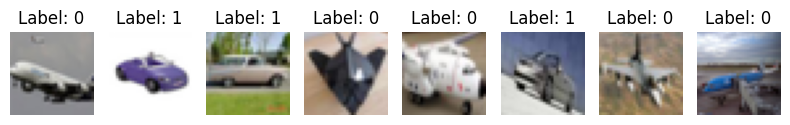

训练集大小: 2048
验证集大小: 512
测试集大小: 1024


In [13]:
# 从 train_loader 中获取 4 个批次的图像和标签
data_iter = iter(train_loader)
images, labels = [], []

for i in range(4):
    X, y = next(data_iter)
    images.append(X)
    labels.append(y)

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)

# 展示图像
fig, axes = plt.subplots(1, 8, figsize=(8, 8))
axes = axes.ravel()
for i in range(8):
    # 调整图像形状：从 (3, 32, 32) 转换为 (32, 32, 3)
    img = images[i].permute(1, 2, 0)  # 调整维度顺序
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 训练集大小
train_size = len(train_loader.dataset)
print("训练集大小:", train_size)

# 验证集大小
valid_size = len(valid_loader.dataset)
print("验证集大小:", valid_size)

# 测试集大小
test_size = len(test_loader.dataset)
print("测试集大小:", test_size)



In [14]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits, 1)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(0)
        for k in range(n_qubits-1):
            self.circuit.cx(k, k+1)
            
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        self.circuit.barrier()

        for i in reversed(range(n_qubits-1)):
            self.circuit.cx(i, i+1)
        self.circuit.h(0)
        self.circuit.measure(0,0)
        
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
#             check = perc
#             for i in range(nr_qubits):
#                 check *= (float(key[i])-1/2)*2
#             expects += check   
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
#        print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
        #backend.set_options(method='automatic', device='GPU')

        results = []
#        print("params:",params)
        for sample_params in params:
            job_sim = backend.run(transpile(self.circuit, backend),
                              parameter_binds=[{self.thetas[k]: sample_params[k].item() for k in range(NUM_QUBITS)}]
                             )
            result_sim = job_sim.result()
            counts = result_sim.get_counts(self.circuit)
            expectation = self.N_qubit_expectation_Z(counts, self.shots, 1)
            results.append(expectation)
            
        return torch.tensor(np.array(results)).to(device)


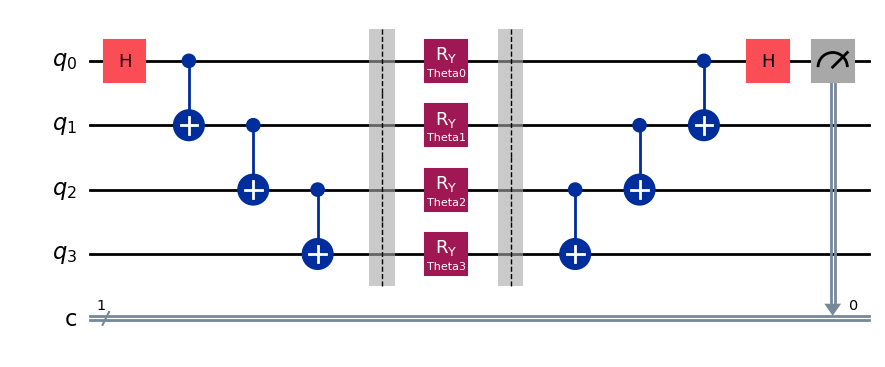

In [15]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
test_params = [np.pi / 2**k for k in range(NUM_QUBITS)]
test_names = ['pi/{}'.format(2**k) for k in range (NUM_QUBITS)]
#print('Expected value for rotation {}: {}'.format(test_names, circuit.run(torch.Tensor(test_params))))
circuit.circuit.draw(output='mpl', filename='./{}-qubit circuit bell.jpg'.format(NUM_QUBITS))

In [16]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
             
        exp_value = ctx.QiskitCirc.run(i)

        result = exp_value.clone().detach().requires_grad_(True)
        #print(result.shape)
        
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor, i = ctx.saved_tensors
        # print('forward_tensor = {}'.format(forward_tensor.shape))
        input_numbers = i
        # print('input_numbers = {}'.format(input_numbers.shape))
        gradients = torch.Tensor()

        gradients = []


        for input_sample in i:
            sample_gradients = []
            for k in range(NUM_QUBITS):
                shift_right = input_sample.detach().clone()
                shift_right[k] = shift_right[k].item() + SHIFT
                shift_left = input_sample.detach().clone()
                shift_left[k] = shift_left[k].item() - SHIFT
                expectation_right = ctx.QiskitCirc.run([shift_right])
                expectation_left = ctx.QiskitCirc.run([shift_left])
                gradient = expectation_right.clone().detach().requires_grad_(True) - expectation_left.clone().detach().requires_grad_(True)
                sample_gradients.append(gradient.float())
            gradients.append(torch.cat(sample_gradients))
        # print("gradients:",gradients.shape)
        result = torch.stack(gradients)

        grad_output = grad_output.view(-1, 1, len(QC_OUTPUTS))
        #print("result:",result.shape,"grad_output:",grad_output.shape)
        transposed = torch.transpose(result.float() * grad_output.float(), 1, 2)
        return transposed[:, 0] + transposed[:, 1]
        #return transposed[:, 0, :] #将(64, len(QC_OUTPUTS), 4)变成(64, 4)


In [17]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(400, 64)
        self.fc2 = Linear(64, 4)  # 2-dimensional input to QNN
        self.qc = TorchCircuit.apply # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        #self.fc3 = Linear(1, 2)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = np.pi*torch.tanh(x)
        # print("进入qc之前的x:",x.shape)
        
#         print('params to QC: {}'.format(x))

        x = self.qc(x) # QUANTUM LAYER
        x = torch.softmax(x)
        return x


model = Net().to(device)
#print(model)

In [18]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


100%|██████████| 32/32 [04:33<00:00,  8.54s/it]


Epoch : 1 - loss : 0.6929 - acc: 0.5122 - val_loss : 0.6906 - val_acc: 0.6133


100%|██████████| 32/32 [04:23<00:00,  8.22s/it]


Epoch : 2 - loss : 0.6891 - acc: 0.6934 - val_loss : 0.6882 - val_acc: 0.7070


100%|██████████| 32/32 [04:23<00:00,  8.22s/it]


Epoch : 3 - loss : 0.6878 - acc: 0.7227 - val_loss : 0.6872 - val_acc: 0.7480


100%|██████████| 32/32 [04:23<00:00,  8.23s/it]


Epoch : 4 - loss : 0.6873 - acc: 0.7427 - val_loss : 0.6874 - val_acc: 0.7305


100%|██████████| 32/32 [04:24<00:00,  8.26s/it]


Epoch : 5 - loss : 0.6869 - acc: 0.7617 - val_loss : 0.6869 - val_acc: 0.7520


100%|██████████| 32/32 [04:23<00:00,  8.25s/it]


Epoch : 6 - loss : 0.6867 - acc: 0.7656 - val_loss : 0.6866 - val_acc: 0.7656


100%|██████████| 32/32 [04:24<00:00,  8.26s/it]


Epoch : 7 - loss : 0.6864 - acc: 0.7773 - val_loss : 0.6865 - val_acc: 0.7656


100%|██████████| 32/32 [04:26<00:00,  8.32s/it]


Epoch : 8 - loss : 0.6863 - acc: 0.7788 - val_loss : 0.6864 - val_acc: 0.7773


100%|██████████| 32/32 [04:25<00:00,  8.31s/it]


Epoch : 9 - loss : 0.6865 - acc: 0.7725 - val_loss : 0.6866 - val_acc: 0.7695


100%|██████████| 32/32 [04:25<00:00,  8.31s/it]


Epoch : 10 - loss : 0.6862 - acc: 0.7793 - val_loss : 0.6868 - val_acc: 0.7578


100%|██████████| 32/32 [04:25<00:00,  8.31s/it]


Epoch : 11 - loss : 0.6858 - acc: 0.7988 - val_loss : 0.6859 - val_acc: 0.8105


100%|██████████| 32/32 [04:26<00:00,  8.31s/it]


Epoch : 12 - loss : 0.6860 - acc: 0.7935 - val_loss : 0.6862 - val_acc: 0.7891


100%|██████████| 32/32 [04:26<00:00,  8.32s/it]


Epoch : 13 - loss : 0.6857 - acc: 0.8008 - val_loss : 0.6860 - val_acc: 0.7852


100%|██████████| 32/32 [04:26<00:00,  8.34s/it]


Epoch : 14 - loss : 0.6859 - acc: 0.7910 - val_loss : 0.6864 - val_acc: 0.7793


100%|██████████| 32/32 [04:26<00:00,  8.34s/it]


Epoch : 15 - loss : 0.6855 - acc: 0.8105 - val_loss : 0.6862 - val_acc: 0.7910


100%|██████████| 32/32 [04:26<00:00,  8.34s/it]


Epoch : 16 - loss : 0.6857 - acc: 0.7964 - val_loss : 0.6861 - val_acc: 0.7812


100%|██████████| 32/32 [04:26<00:00,  8.33s/it]


Epoch : 17 - loss : 0.6854 - acc: 0.8105 - val_loss : 0.6864 - val_acc: 0.7734


100%|██████████| 32/32 [04:27<00:00,  8.35s/it]


Epoch : 18 - loss : 0.6856 - acc: 0.8042 - val_loss : 0.6863 - val_acc: 0.7773


100%|██████████| 32/32 [04:26<00:00,  8.33s/it]


Epoch : 19 - loss : 0.6853 - acc: 0.8110 - val_loss : 0.6865 - val_acc: 0.7754


100%|██████████| 32/32 [04:26<00:00,  8.34s/it]


Epoch : 20 - loss : 0.6853 - acc: 0.8110 - val_loss : 0.6858 - val_acc: 0.7988


100%|██████████| 32/32 [04:26<00:00,  8.34s/it]


Epoch : 21 - loss : 0.6852 - acc: 0.8247 - val_loss : 0.6859 - val_acc: 0.7910


100%|██████████| 32/32 [04:27<00:00,  8.35s/it]


Epoch : 22 - loss : 0.6851 - acc: 0.8218 - val_loss : 0.6859 - val_acc: 0.7871


100%|██████████| 32/32 [04:27<00:00,  8.36s/it]


Epoch : 23 - loss : 0.6853 - acc: 0.8130 - val_loss : 0.6862 - val_acc: 0.7715


100%|██████████| 32/32 [04:27<00:00,  8.35s/it]


Epoch : 24 - loss : 0.6851 - acc: 0.8247 - val_loss : 0.6858 - val_acc: 0.7930


100%|██████████| 32/32 [04:27<00:00,  8.35s/it]


Epoch : 25 - loss : 0.6854 - acc: 0.8086 - val_loss : 0.6856 - val_acc: 0.8008


100%|██████████| 32/32 [04:27<00:00,  8.37s/it]


Epoch : 26 - loss : 0.6856 - acc: 0.8013 - val_loss : 0.6856 - val_acc: 0.8066


100%|██████████| 32/32 [04:27<00:00,  8.37s/it]


Epoch : 27 - loss : 0.6852 - acc: 0.8125 - val_loss : 0.6856 - val_acc: 0.8008


100%|██████████| 32/32 [04:28<00:00,  8.40s/it]


Epoch : 28 - loss : 0.6852 - acc: 0.8179 - val_loss : 0.6857 - val_acc: 0.8047


100%|██████████| 32/32 [04:27<00:00,  8.36s/it]


Epoch : 29 - loss : 0.6851 - acc: 0.8237 - val_loss : 0.6859 - val_acc: 0.7949


100%|██████████| 32/32 [04:28<00:00,  8.40s/it]


Epoch : 30 - loss : 0.6848 - acc: 0.8340 - val_loss : 0.6856 - val_acc: 0.7969


100%|██████████| 32/32 [04:28<00:00,  8.40s/it]


Epoch : 31 - loss : 0.6850 - acc: 0.8184 - val_loss : 0.6857 - val_acc: 0.7988


100%|██████████| 32/32 [04:28<00:00,  8.41s/it]


Epoch : 32 - loss : 0.6854 - acc: 0.8096 - val_loss : 0.6854 - val_acc: 0.8008


100%|██████████| 32/32 [04:32<00:00,  8.51s/it]


Epoch : 33 - loss : 0.6850 - acc: 0.8218 - val_loss : 0.6855 - val_acc: 0.8047


100%|██████████| 32/32 [04:28<00:00,  8.40s/it]


Epoch : 34 - loss : 0.6851 - acc: 0.8193 - val_loss : 0.6855 - val_acc: 0.8027


100%|██████████| 32/32 [04:27<00:00,  8.37s/it]


Epoch : 35 - loss : 0.6851 - acc: 0.8174 - val_loss : 0.6854 - val_acc: 0.8164


100%|██████████| 32/32 [04:26<00:00,  8.33s/it]


Epoch : 36 - loss : 0.6848 - acc: 0.8315 - val_loss : 0.6860 - val_acc: 0.7812


100%|██████████| 32/32 [04:26<00:00,  8.33s/it]


Epoch : 37 - loss : 0.6848 - acc: 0.8330 - val_loss : 0.6854 - val_acc: 0.8145


100%|██████████| 32/32 [04:28<00:00,  8.39s/it]


Epoch : 38 - loss : 0.6850 - acc: 0.8291 - val_loss : 0.6852 - val_acc: 0.8242


100%|██████████| 32/32 [04:27<00:00,  8.37s/it]


Epoch : 39 - loss : 0.6851 - acc: 0.8184 - val_loss : 0.6854 - val_acc: 0.8047


100%|██████████| 32/32 [04:26<00:00,  8.34s/it]


Epoch : 40 - loss : 0.6849 - acc: 0.8301 - val_loss : 0.6857 - val_acc: 0.8008


100%|██████████| 32/32 [04:27<00:00,  8.35s/it]


Epoch : 41 - loss : 0.6849 - acc: 0.8325 - val_loss : 0.6855 - val_acc: 0.8066


100%|██████████| 32/32 [04:42<00:00,  8.82s/it]


Epoch : 42 - loss : 0.6847 - acc: 0.8374 - val_loss : 0.6857 - val_acc: 0.8008


100%|██████████| 32/32 [04:45<00:00,  8.93s/it]


Epoch : 43 - loss : 0.6846 - acc: 0.8359 - val_loss : 0.6854 - val_acc: 0.8105


100%|██████████| 32/32 [04:43<00:00,  8.85s/it]


Epoch : 44 - loss : 0.6847 - acc: 0.8354 - val_loss : 0.6854 - val_acc: 0.8066


100%|██████████| 32/32 [04:43<00:00,  8.87s/it]


Epoch : 45 - loss : 0.6847 - acc: 0.8364 - val_loss : 0.6854 - val_acc: 0.8086


100%|██████████| 32/32 [04:44<00:00,  8.89s/it]


Epoch : 46 - loss : 0.6843 - acc: 0.8521 - val_loss : 0.6855 - val_acc: 0.8066


100%|██████████| 32/32 [04:49<00:00,  9.06s/it]


Epoch : 47 - loss : 0.6847 - acc: 0.8389 - val_loss : 0.6855 - val_acc: 0.8066


100%|██████████| 32/32 [04:50<00:00,  9.07s/it]


Epoch : 48 - loss : 0.6847 - acc: 0.8354 - val_loss : 0.6852 - val_acc: 0.8184


100%|██████████| 32/32 [04:50<00:00,  9.08s/it]


Epoch : 49 - loss : 0.6845 - acc: 0.8413 - val_loss : 0.6855 - val_acc: 0.8027


100%|██████████| 32/32 [04:52<00:00,  9.14s/it]


Epoch : 50 - loss : 0.6846 - acc: 0.8394 - val_loss : 0.6856 - val_acc: 0.7949


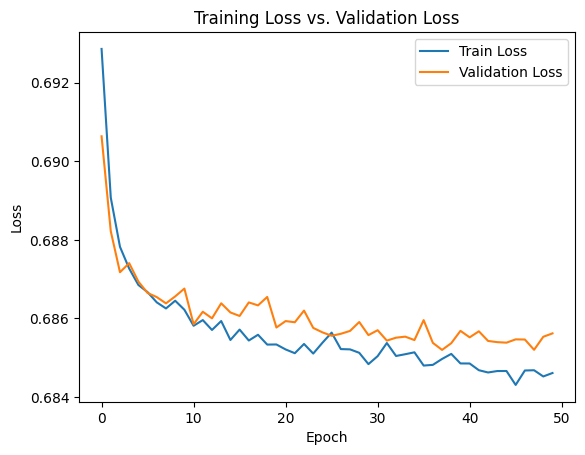

In [19]:
import logging

# 设置日志记录器
log_file = "training_QC.log"
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')

# 开始训练
epochs = 50
model.train()

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    
    log_message = f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}"
    logging.info(log_message)  # 将训练日志记录到文件中

    if epoch % 1 == 0:
        print(log_message)
        
    torch.save(model.state_dict(), "model_QC.pt")

# 将列表转换为张量
train_losses_tensor = torch.Tensor(train_losses)
val_losses_tensor = torch.Tensor(val_losses)

# 绘制损失曲线
plt.plot(train_losses_tensor.cpu().numpy(), label='Train Loss')
plt.plot(val_losses_tensor.cpu().numpy(), label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Validation Loss')
plt.savefig('./loss_image_QC.png')
plt.show()

In [23]:
model = Net().to(device)
model.load_state_dict(torch.load("model_QC.pt"))


<All keys matched successfully>

In [24]:
model.eval()  # set model to evaluation mode
with no_grad():
    total_loss = []
    correct = 0
    all_ = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_ += len(target)

        loss = criterion(output, target)
        total_loss.append(loss.item())
    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / all_ * 100
        )
    )


Performance on test data:
	Loss: 0.6847
	Accuracy: 83.5%


TypeError: Invalid shape (3, 32, 32) for image data

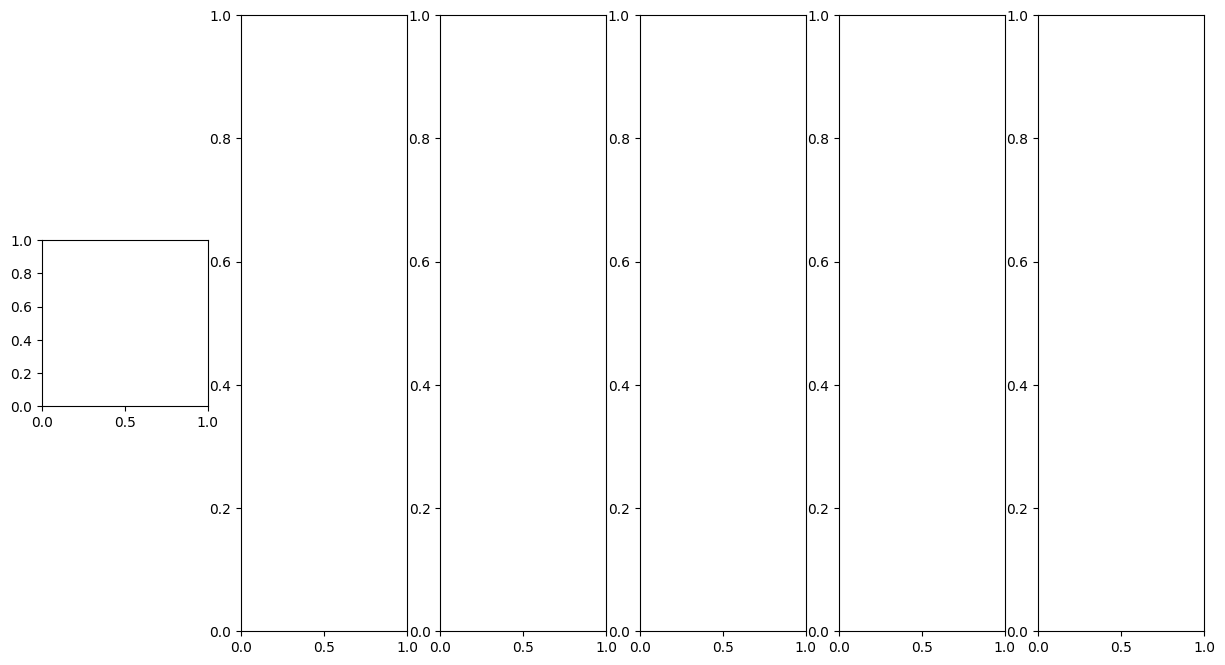

In [22]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 8))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)

        for i in range(data.shape[0]):
            if count == n_samples_show:
                break

            output = model(data[i:i+1])  # 处理单个数据样本
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)

            pred = output.argmax(dim=1, keepdim=True)

            axes[count].imshow(data[i].cpu().numpy().squeeze(), cmap="gray")
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title("Predicted {}".format(pred.item()))

            count += 1

        if count == n_samples_show:
            break
